# Modeling and Simulation in Python

Chapter 6

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [3]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

from pandas import read_html

### Code from the previous chapter



In [4]:
filename = 'data/World_population_estimates.html'
html_link = 'https://en.wikipedia.org/wiki/Estimates_of_historical_world_population'

tables = read_html(html_link, header=0, index_col=0, decimal='M')
table2 = tables[2]
table2.columns = ['census', 'prb', 'un', 'maddison', 
                  'hyde', 'tanton', 'biraben', 'mj', 
                  'thomlinson', 'durand', 'clark']

In [5]:
un = table2.un / 1e9
un.head()

Year
1950    2.525149
1951    2.572851
1952    2.619292
1953    2.665865
1954    2.713172
Name: un, dtype: float64

In [6]:
census = table2.census / 1e9
census.head()

Year
1950    2.557629
1951    2.594940
1952    2.636772
1953    2.682053
1954    2.730228
Name: census, dtype: float64

In [7]:
t_0 = get_first_label(census)
t_end = get_last_label(census)
elapsed_time = t_end - t_0

p_0 = get_first_value(census)
p_end = get_last_value(census)
total_growth = p_end - p_0

annual_growth = total_growth / elapsed_time

0.07224800083333333

### System objects

We can rewrite the code from the previous chapter using system objects.

In [8]:
system = System(t_0=t_0, 
                t_end=t_end,
                p_0=p_0,
                annual_growth=annual_growth)

,values
t_0,1950.000000
t_end,2016.000000
p_0,2.557629
annual_growth,0.072248


And we can encapsulate the code that runs the model in a function.

In [9]:
def run_simulation1(system):
    """Runs the constant growth model.
    
    system: System object
    
    returns: TimeSeries
    """
    results = TimeSeries()
    results[system.t_0] = system.p_0
    
    for t in linrange(system.t_0, system.t_end):
        results[t+1] = results[t] + system.annual_growth
    
    return results

We can also encapsulate the code that plots the results.

In [10]:
def plot_results(census, un, timeseries, title):
    """Plot the estimates and the model.
    
    census: TimeSeries of population estimates
    un: TimeSeries of population estimates
    timeseries: TimeSeries of simulation results
    title: string
    """
    plot(census, ':', label='US Census')
    plot(un, '--', label='UN DESA')
    plot(timeseries, color='gray', label='model')
    
    decorate(xlabel='Year', 
             ylabel='World population (billion)',
             title=title)

Here's how we run it.

In [14]:
type(results)

modsim.modsim.TimeSeries

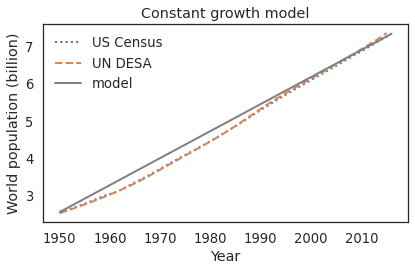

In [11]:
results = run_simulation1(system)
plot_results(census, un, results, 'Constant growth model')

## Proportional growth

Here's a more realistic model where the number of births and deaths is proportional to the current population.

In [10]:
def run_simulation2(system):
    """Run a model with proportional birth and death.
    
    system: System object
    
    returns: TimeSeries
    """
    results = TimeSeries()
    results[system.t_0] = system.p_0
    
    for t in linrange(system.t_0, system.t_end):
        births = system.birth_rate * results[t]
        deaths = system.death_rate * results[t]
        results[t+1] = results[t] + births - deaths
        
    return results

I picked a death rate that seemed reasonable and then adjusted the birth rate to fit the data.

In [11]:
system.death_rate = 0.01
system.birth_rate = 0.027

Here's what it looks like.

Saving figure to file figs/chap06-fig01.pdf


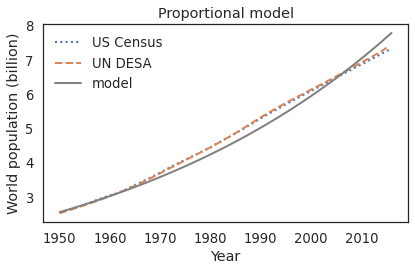

In [13]:
results = run_simulation2(system)
plot_results(census, un, results, 'Proportional model')
savefig('figs/chap06-fig01.pdf')

The model fits the data pretty well for the first 20 years, but not so well after that.

### Factoring out the update function

`run_simulation1` and `run_simulation2` are nearly identical except the body of the loop.  So we can factor that part out into a function.

In [24]:
def update_func1(pop, t, system, show):
    """Compute the population next year.
    
    pop: current population
    t: current year
    system: system object containing parameters of the model
    
    returns: population next year
    """
    if show:
        print(f'Population: {round(pop,3)}\t Year: {t}')
    births = system.birth_rate * pop
    deaths = system.death_rate * pop
    return pop + births - deaths

The name `update_func` refers to a function object.

In [25]:
update_func1

<function __main__.update_func1(pop, t, system, show)>

Which we can confirm by checking its type.

In [26]:
type(update_func1)

function

`run_simulation` takes the update function as a parameter and calls it just like any other function.

In [27]:
def run_simulation(system, update_func, show=False):
    """Simulate the system using any update function.
    
    system: System object
    update_func: function that computes the population next year
    
    returns: TimeSeries
    """
    results = TimeSeries()
    results[system.t_0] = system.p_0
    
    for t in linrange(system.t_0, system.t_end):
        results[t+1] = update_func(results[t], t, system, show)
        
    return results

Here's how we use it.

In [28]:
t_0 = get_first_label(census)
t_end = get_last_label(census)
p_0 = census[t_0]

system = System(t_0=t_0, 
                t_end=t_end,
                p_0=p_0,
                birth_rate=0.027,
                death_rate=0.01)

,values
t_0,1950.000000
t_end,2016.000000
p_0,2.557629
birth_rate,0.027000
death_rate,0.010000


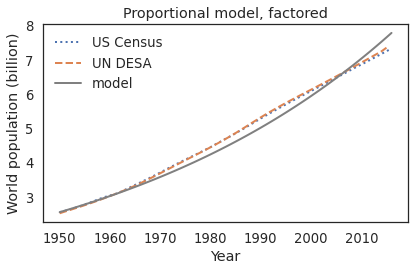

In [29]:
results = run_simulation(system, update_func1)
plot_results(census, un, results, 'Proportional model, factored')

Remember not to put parentheses after `update_func1`.  What happens if you try?

If you put the `()` the function runs in the signature and that causes a 
`TypeError: update_func1() missing 3 required positional arguments: 'pop', 't', and 'system'`
since we didn't supply any parameters


**Exercise:** When you run `run_simulation`, it runs `update_func1` once for each year between `t_0` and `t_end`.  To see that for yourself, add a print statement at the beginning of `update_func1` that prints the values of `t` and `pop`, then run `run_simulation` again.

Population: 2.558	 Year: 1950
Population: 2.601	 Year: 1951
Population: 2.645	 Year: 1952
Population: 2.69	 Year: 1953
Population: 2.736	 Year: 1954
Population: 2.783	 Year: 1955
Population: 2.83	 Year: 1956
Population: 2.878	 Year: 1957
Population: 2.927	 Year: 1958
Population: 2.977	 Year: 1959
Population: 3.027	 Year: 1960
Population: 3.079	 Year: 1961
Population: 3.131	 Year: 1962
Population: 3.184	 Year: 1963
Population: 3.238	 Year: 1964
Population: 3.293	 Year: 1965
Population: 3.349	 Year: 1966
Population: 3.406	 Year: 1967
Population: 3.464	 Year: 1968
Population: 3.523	 Year: 1969
Population: 3.583	 Year: 1970
Population: 3.644	 Year: 1971
Population: 3.706	 Year: 1972
Population: 3.769	 Year: 1973
Population: 3.833	 Year: 1974
Population: 3.898	 Year: 1975
Population: 3.964	 Year: 1976
Population: 4.032	 Year: 1977
Population: 4.1	 Year: 1978
Population: 4.17	 Year: 1979
Population: 4.241	 Year: 1980
Population: 4.313	 Year: 1981
Population: 4.386	 Year: 1982
Population: 4.4

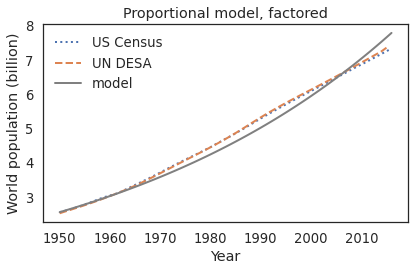

In [30]:
results = run_simulation(system, update_func1, True)
plot_results(census, un, results, 'Proportional model, factored')

### Combining birth and death

Since births and deaths get added up, we don't have to compute them separately.  We can combine the birth and death rates into a single net growth rate.

In [34]:
def update_func2(pop, t, system, show):
    """Compute the population next year.
    
    pop: current population
    t: current year
    system: system object containing parameters of the model
    
    returns: population next year
    """
    net_growth = system.alpha  * pop
    return pop + net_growth

Here's how it works:

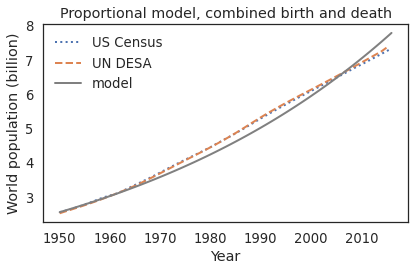

In [35]:
system.alpha = system.birth_rate - system.death_rate

results = run_simulation(system, update_func2)
plot_results(census, un, results, 'Proportional model, combined birth and death')

### Exercises

**Exercise:** Maybe the reason the proportional model doesn't work very well is that the growth rate, `alpha`, is changing over time.  So let's try a model with different growth rates before and after 1980 (as an arbitrary choice).

Write an update function that takes `pop`, `t`, and `system` as parameters.  The system object, `system`, should contain two parameters: the growth rate before 1980, `alpha1`, and the growth rate after 1980, `alpha2`.  It should use `t` to determine which growth rate to use.  Note: Don't forget the `return` statement.

Test your function by calling it directly, then pass it to `run_simulation`.  Plot the results.  Adjust the parameters `alpha1` and `alpha2` to fit the data as well as you can.



In [87]:
system.before_1980 = 0.019
system.after_1980 = 0.0142

In [94]:
def update_func3(pop, t, system, show):
    if t <1980:
        alpha = system.before_1980
    else:
        alpha = system.after_1980
    net_growth = alpha  * pop
    if show:
        print(f'True Pop: {round(pop,4)}\tPredict Pop{round(pop + net_growth,4)}\tYear:{t}')
    return pop + net_growth

True Pop: 2.5576	Predict Pop2.6062	Year:1950
True Pop: 2.6062	Predict Pop2.6557	Year:1951
True Pop: 2.6557	Predict Pop2.7062	Year:1952
True Pop: 2.7062	Predict Pop2.7576	Year:1953
True Pop: 2.7576	Predict Pop2.81	Year:1954
True Pop: 2.81	Predict Pop2.8634	Year:1955
True Pop: 2.8634	Predict Pop2.9178	Year:1956
True Pop: 2.9178	Predict Pop2.9732	Year:1957
True Pop: 2.9732	Predict Pop3.0297	Year:1958
True Pop: 3.0297	Predict Pop3.0873	Year:1959
True Pop: 3.0873	Predict Pop3.146	Year:1960
True Pop: 3.146	Predict Pop3.2057	Year:1961
True Pop: 3.2057	Predict Pop3.2666	Year:1962
True Pop: 3.2666	Predict Pop3.3287	Year:1963
True Pop: 3.3287	Predict Pop3.392	Year:1964
True Pop: 3.392	Predict Pop3.4564	Year:1965
True Pop: 3.4564	Predict Pop3.5221	Year:1966
True Pop: 3.5221	Predict Pop3.589	Year:1967
True Pop: 3.589	Predict Pop3.6572	Year:1968
True Pop: 3.6572	Predict Pop3.7267	Year:1969
True Pop: 3.7267	Predict Pop3.7975	Year:1970
True Pop: 3.7975	Predict Pop3.8696	Year:1971
True Pop: 3.8696	Pre

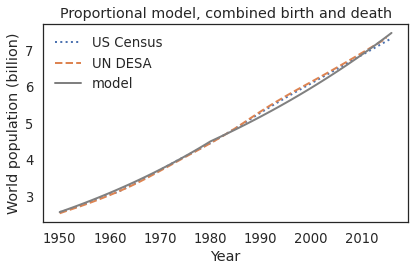

In [95]:
results = run_simulation(system, update_func3, True)
plot_results(census, un, results, 'Proportional model, combined birth and death')